# Fast Lomb-Scargle Periodograms in Python

The Lomb-Scargle Periodogram is a well-known method of finding periodicity in irregularly-sampled time-series data.
The common implementation of the periodogram is relatively slow: for $N$ data points, a frequency grid of $\sim N$ frequencies is required and the computation scales as $O[N^2]$.
In a 1989 paper, Press and Rybicki presented a faster technique which makes use of fast Fourier transforms to reduce this cost to $O[N\log N]$ on a regular frequency grid.
The ``gatspy`` package implement this in the ``LombScargleFast`` object, which we'll explore below.

But first, we'll motivate *why* this algorithm is needed at all.
We'll start this notebook with some standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# use seaborn's default plotting styles for matplotlib
import seaborn; seaborn.set()

To begin, let's make a function which will create $N$ noisy, irregularly-spaced data points containing a periodic signal, and plot one realization of that data:

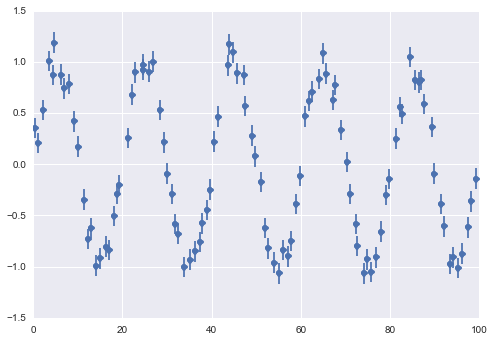

In [2]:
def create_data(N, period=2.5, err=0.1, rseed=0):
    rng = np.random.RandomState(rseed)
    t = np.arange(N, dtype=float) + 0.3 * rng.randn(N)
    y = np.sin(2 * np.pi * t / period) + err * rng.randn(N)
    return t, y, err

t, y, dy = create_data(100, period=20)
plt.errorbar(t, y, dy, fmt='o');

From this, our algorithm should be able to identify any periodicity that is present.

## Choosing the Frequency Grid
The Lomb-Scargle Periodogram works by evaluating a power for a set of candidate frequencies $f$. So the first question is, how many candidate frequencies should we choose?
It turns out that this question is *very* important. If you choose the frequency spacing poorly, it may lead you to miss strong periodic signal in the data!

### Frequency spacing
First, let's think about the frequency spacing we need in our grid. If you're asking about a candidate frequency $f$, then data with range $T$ contains $T \cdot f$ complete cycles. If our error in frequency is $\delta f$, then $T\cdot\delta f$ is the error in number of cycles between the endpoints of the data.
If this error is a significant fraction of a cycle, this will cause problems. This givs us the criterion
$$
T\cdot\delta f \ll 1
$$
Commonly, we'll choose some oversampling factor around 5 and use $\delta f = (5T)^{-1}$ as our frequency grid spacing.

### Frequency limits
Next, we need to choose the limits of the frequency grid. On the low end, $f=0$ is suitable, but causes some problems – we'll go one step away and use $\delta f$ as our minimum frequency.
But on the high end, we need to make a choice: what's the highest frequency we'd trust our data to be sensitive to?
At this point, many people are tempted to mis-apply the Nyquist-Shannon sampling theorem, and choose some version of the Nyquist limit for the data.
But this is entirely wrong! The Nyquist frequency applies for regularly-sampled data, but irregularly-sampled data can be sensitive to much, much higher frequencies, and the upper limit should be determined based on what kind of signals you are looking for.

Still, a common (if dubious) rule-of-thumb is that the high frequency is some multiple of what Press & Rybicki call the "average" Nyquist frequency,
$$
\hat{f}_{Ny} = \frac{N}{2T}
$$
With this in mind, we'll use the following function to determine a suitable frequency grid:

In [3]:
def freq_grid(t, oversampling=5, nyquist_factor=3):
    T = t.max() - t.min()
    N = len(t)
    
    df = 1. / (oversampling * T)
    fmax = 0.5 * nyquist_factor * N / T
    N = int(fmax // df)
    return df + df * np.arange(N)

Now let's use the ``gatspy`` tools to plot the periodogram:

In [4]:
t, y, dy = create_data(100, period=2.5)
freq = freq_grid(t)
print(len(freq))

750


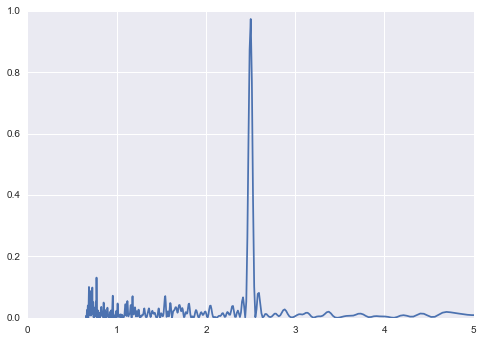

In [5]:
from gatspy.periodic import LombScargle
model = LombScargle().fit(t, y, dy)
period = 1. / freq
power = model.periodogram(period)
plt.plot(period, power)
plt.xlim(0, 5);

The algorithm finds a strong signal at a period of 2.5.

To demonstrate explicitly that the Nyquist rate doesn't apply in irregularly-sampled data, let's use a period below the averaged sampling rate and show that we can find it:

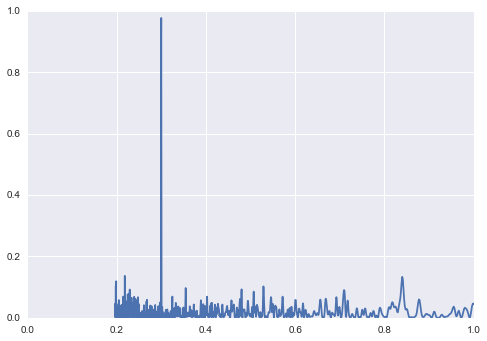

In [6]:
t, y, dy = create_data(100, period=0.3)
period = 1. / freq_grid(t, nyquist_factor=10)

model = LombScargle().fit(t, y, dy)
power = model.periodogram(period)
plt.plot(period, power)
plt.xlim(0, 1);

With a data sampling rate of approximately $1$ time unit, we easily find a period of $0.3$ time units. The averaged Nyquist limit clearly does not apply for irregularly-spaced data!
Nevertheless, short of a full analysis of the temporal window function, it remains a useful milepost in estimating the upper limit of frequency.

### Scaling with $N$
With these rules in mind, we see that the size of the frequency grid is approximately
$$
N_f = \frac{f_{max}}{\delta f} \propto \frac{N/(2T)}{1/T} \propto N
$$
So for $N$ data points, we will require some multiple of $N$ frequencies (with a constant of proportionality typically on order 10) to suitably explore the frequency space.
This is the source of the $N^2$ scaling of the typical periodogram: finding periods in $N$ datapoints requires a grid of $\sim 10N$ frequencies, and $O[N^2]$ operations.
When $N$ gets very, very large, this becomes a problem.

## Fast Periodograms with ``LombScargleFast``
Finally we get to the meat of this discussion.

In a [1989 paper](http://adsabs.harvard.edu/full/1989ApJ...338..277P), Press and Rybicki proposed a clever method whereby a Fast Fourier Transform is used on a grid *extirpolated* from the original data, such that this problem can be solved in $O[N\log N]$ time. The ``gatspy`` package contains a pure-Python implementation of this algorithm, and we'll explore it here.
If you're interested in seeing how the algorithm works in Python, check out the code in [the gatspy source](https://github.com/astroML/gatspy/blob/master/gatspy/periodic/lomb_scargle_fast.py).
It's far more readible and understandable than the Fortran source presented in Press *et al.*

For convenience, the implementation has a ``periodogram_auto`` method which automatically selects a frequency/period range based on an oversampling factor and a nyquist factor:

In [7]:
from gatspy.periodic import LombScargleFast
help(LombScargleFast.periodogram_auto)

Help on function periodogram_auto in module gatspy.periodic.modeler:

periodogram_auto(self, oversampling=5, nyquist_factor=3, return_periods=True)
    Compute the periodogram on an automatically-determined grid
    
    This function uses heuristic arguments to choose a suitable frequency
    grid for the data. Note that depending on the data window function,
    the model may be sensitive to periodicity at higher frequencies than
    this function returns!
    
    The final number of frequencies will be
    Nf = oversampling * nyquist_factor * len(t) / 2
    
    Parameters
    ----------
    oversampling : float
        the number of samples per approximate peak width
    nyquist_factor : float
        the highest frequency, in units of the nyquist frequency for points
        spread uniformly through the data range.
    
    Returns
    -------
    period : ndarray
        the grid of periods
    power : ndarray
        the power at each frequency



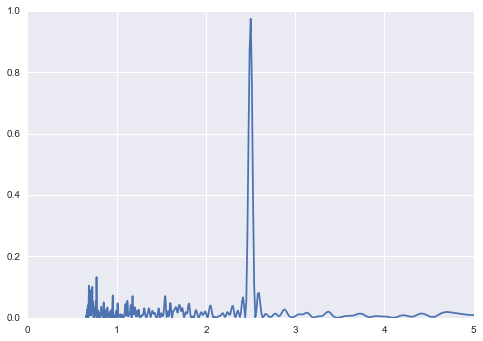

In [8]:
from gatspy.periodic import LombScargleFast

t, y, dy = create_data(100)
model = LombScargleFast().fit(t, y, dy)
period, power = model.periodogram_auto()
plt.plot(period, power)
plt.xlim(0, 5);

Here, to illustrate the different computational scalings, we'll evaluate the computational time for a number of inputs, using ``LombScargleAstroML`` (a fast implementation of the $O[N^2]$ algorithm) and ``LombScargleFast``, which is the fast FFT-based implementation:

In [9]:
from time import time
from gatspy.periodic import LombScargleAstroML, LombScargleFast
            

def get_time(N, Model):
    t, y, dy = create_data(N)
        
    model = Model().fit(t, y, dy)
    t0 = time()
    model.periodogram_auto()
    t1 = time()
    result = t1 - t0
    
    # for fast operations, we should do several and take the median
    if result < 0.1:
        N = min(50, 0.5 / result)
        times = []
        for i in range(5):
            t0 = time()
            model.periodogram_auto()
            t1 = time()
            times.append(t1 - t0)
        result = np.median(times)
    return result

N_obs = list(map(int, 10 ** np.linspace(1, 4, 5)))
times1 = [get_time(N, LombScargleAstroML) for N in N_obs]
times2 = [get_time(N, LombScargleFast) for N in N_obs]

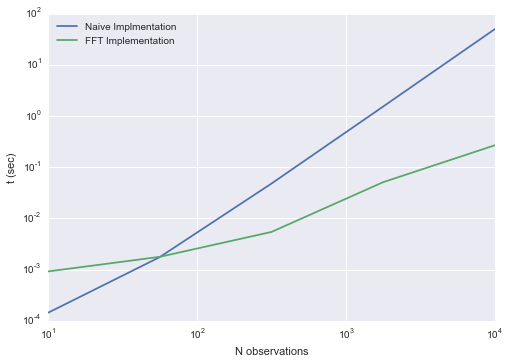

In [10]:
plt.loglog(N_obs, times1, label='Naive Implmentation')
plt.loglog(N_obs, times2, label='FFT Implementation')
plt.xlabel('N observations')
plt.ylabel('t (sec)')
plt.legend(loc='upper left');

For fewer than 100 observations, the naive implementation wins out, but as the number of points grows, we observe the clear trends in scaling: $O[N^2]$ for the Naive method, and $O[N\log N]$ for the fast method. We could push this plot higher, but the trends are already clear: for $10^5$ points, while the FFT method would complete in a couple seconds, the Naive method would take nearly two hours! Who's got the time for that plot?